# Exploring Climate Data: Past and Future
## Roland Viger, Rich Signell, USGS
Original version presented at the 2012 Unidata Workshop: Navigating Earth System Science Data, 9-13 July.  Updated in October 2017 to use pandas, xarray, and new python-3 version of pyGDP.

What if you were watching [Ken Burns's "The Dust Bowl"](http://www.pbs.org/kenburns/dustbowl/), saw the striking image below, and wondered: "How much precipitation there really was back in the dustbowl years?"  How easy is it to access and manipulate climate data in a scientific analysis?  Here we'll show some powerful tools that make it easy.



![image_dust](http://www.pbs.org/kenburns/dustbowl/media/photos/s2571-lg.jpg)

Above:Dust storm hits Hooker, OK, June 4, 1937. 

To find out how much rainfall was there during the dust bowl years, we can use the [USGS/CIDA GeoDataPortal (GDP)](http://cida.usgs.gov/climate/gdp/) which can compute statistics of a gridded field within specified shapes, such as county outlines.  Hooker is in Texas County, Oklahoma, so here we use the GDP to compute a historical time series of mean precipitation in Texas County using the PRISM dataset. We then compare to climate forecast projections to see if similar droughts are predicted to occur in the future, and what the impact of different climate scenarios might be. 

One way to interface with the GDP is with the interactive web interface, shown below.  In this interface, you can upload a shapefile or draw on the screen to define a polygon region, then you specify the statistics and datasets you want to use via dropdown menus.  

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://screencast.com/t/K7KTcaFrSUc width=800 height=600></iframe>')

Use pyGDP (Python interface) for programmatic Python access to the USGS Geo Data Portal services

In [2]:
import pyGDP

# Create a pyGDP object
myGDP = pyGDP.pyGDPwebProcessing()

In [3]:
# Let's see what shapefiles are already available on the GDP server
# this changes with time, since uploaded shapefiles are kept for a few days

shapefiles = myGDP.getShapefiles()

print('Available Shapefiles:')
for s in shapefiles:
    print(s)

/home/rsignell/.conda/envs/pygdp/lib/python3.6/site-packages/owslib/util.py:540: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if elements:


Available Shapefiles:
draw:AOI
sample:Alaska
upload:CC_WS_Del
upload:CIDA_TEST_
sample:CONUS_Climate_Divisions
derivative:CONUS_States
sample:CONUS_states
sample:CSC_Boundaries
upload:ClearCr_PP
upload:ClrCr_PP
upload:ClrCrk
upload:ClrCrkzip
sample:Counties
sample:Ecoregions_Level_III
derivative:FWS_LCC
upload:Kings_outline
upload:Lab7
sample:Lanscape_Conservation_Cooperatives
derivative:Level_III_Ecoregions
upload:LongPro
upload:Map
sample:NCA_Regions
upload:OKCNTYD
draw:URG
derivative:US_Counties
upload:WS_Clear_Creek_Del
upload:WS_proj
upload:WS_proj2
upload:_11491400_will_sheep
upload:_11492400_big_springs
upload:_11493500_will_klam_agency
upload:_11497500_sprague_beatty
upload:_11499100_sycan
upload:_11501000_sprague_chilo
upload:_11502500_will_chilo
upload:_11502940_wood_dixon
upload:_11504115_wood_klam
upload:_11507500_klam_link
draw:asdf
derivative:climate_divisions
upload:domain
upload:first_half_hrus_repair
upload:huc10areas
draw:man
upload:manateecounty
upload:manocounty
upl

In [4]:
# Is our shapefile there already?
# If not, upload it. 

OKshapeFile = 'upload:OKCNTYD'

if not OKshapeFile in shapefiles:
    shpfile = myGDP.uploadShapeFile('OKCNTYD.zip')

In [5]:
# Let's check the attributes of the shapefile

attributes = myGDP.getAttributes(OKshapeFile)
print("Shapefile attributes:")
for a in attributes:
    print(a)

Shapefile attributes:
OBJECTID_1
OBJECTID
RECTYPE
VERSION
REVISION
MODDATE
POLYID
FEATUREID
CNTRLONG
CNTRLAT
DESCRIP
STFIPS
Shape_area
Shape_len


In [6]:
# In this particular example, we are interested in attribute = 'DESCRIP', 
# which provides the County names for Oklahoma

user_attribute = 'DESCRIP'

values = myGDP.getValues(OKshapeFile, user_attribute)

print("Shapefile attribute values:")
for v in values:
    print(v)

Shapefile attribute values:
Adair
Alfalfa
Atoka
Beaver
Beckham
Blaine
Bryan
Caddo
Canadian
Carter
Cherokee
Choctaw
Cimarron
Cleveland
Coal
Comanche
Cotton
Craig
Creek
Custer
Delaware
Dewey
Ellis
Garfield
Garvin
Grady
Grant
Greer
Harmon
Harper
Haskell
Hughes
Jackson
Jefferson
Johnston
Kay
Kingfisher
Kiowa
Latimer
Le Flore
Lincoln
Logan
Love
Major
Marshall
Mayes
McClain
McCurtain
McIntosh
Murray
Muskogee
Noble
Nowata
Okfuskee
Oklahoma
Okmulgee
Osage
Ottawa
Pawnee
Payne
Pittsburg
Pontotoc
Pottawatomie
Pushmataha
Roger Mills
Rogers
Seminole
Sequoyah
Stephens
Texas
Tillman
Tulsa
Wagoner
Washington
Washita
Woods
Woodward


In [7]:
# Hooker is located in Texas County
user_value = 'Texas'

In [8]:
# Specify an OPeNDAP URL (does not have to be from CIDA!)

datasetURL = 'https://cida.usgs.gov/thredds/dodsC/prism_v2'

dataTypes = myGDP.getDataType(datasetURL)

# Let's see what data variables are in our dataset

print("Available variables:")
for d in dataTypes:
    print(d)

Available variables:
ppt
tmx
tmn


In [9]:
# Let's see what the available time range is for our data variable

user_dataType = 'ppt'  # precip

timeRange = myGDP.getTimeRange(datasetURL, user_dataType)
for t in timeRange:
    print(t)

1895-01-01T00:00:00Z
2015-12-01T00:00:00Z


In [10]:
timeBegin = '1900-01-01T00:00:00Z'
timeEnd   = '2015-08-01T00:00:00Z'

In [11]:
import os

fname = 'prism.csv'

if not os.path.isfile(fname):
    csv = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, datasetURL,
        user_dataType, timeBegin, timeEnd, user_attribute, user_value,
        delim='COMMA', stat='MEAN')
    os.rename(csv, fname)

prism_csv = fname

In [12]:
import pandas as pd

prism = pd.read_csv(prism_csv, skiprows=3, names=['time','PRISM'], index_col='time', parse_dates=True)

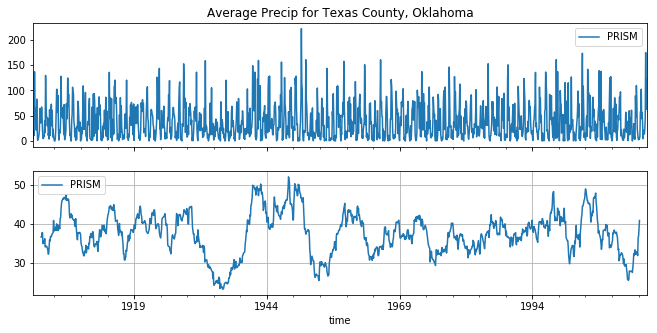

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True,figsize=(11, 5))

prism_filt = prism.rolling(window=36, center=True).mean()

ax = prism.plot(ax=ax0)
ax.set_title('Average Precip for Texas County, Oklahoma')

ax1 = prism_filt.plot(ax=ax1)
ax1.grid(True)

In [14]:
HTML('<iframe src=http://www.ipcc-data.org/sim/gcm_monthly/AR5/CMIP5-Experiments.html width=900 height=350></iframe>')

In [15]:
# Retrieve the CCSM4 model RCP8.5 "Worst Case" scenario:
datasetURL = 'https://cida.usgs.gov/thredds/dodsC/cmip5_bcsd/historical_1'
dataType = 'BCSD_0-125deg_pr_Amon_CCSM4_historical_r1i1p1_195001-200512'
timeRange = myGDP.getTimeRange(datasetURL, dataType)

timeRange

['1950-01-14T12:00:00Z', '2005-12-14T12:00:00Z']

In [16]:
fname = 'gdp_texas_county_ccsm4_historical_r1i1p1.csv'
if not os.path.isfile(fname):
    csv = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, datasetURL,
            user_dataType, timeBegin, timeEnd, user_attribute, user_value,
            delim='COMMA', stat='MEAN')
    os.rename(csv, fname)

h1_csv = fname

In [17]:
# Retrieve the CCSM4 model RCP8.5 "Worst Case" scenario:
datasetURL = 'https://cida.usgs.gov/thredds/dodsC/cmip5_bcsd/future_2'
dataType = 'BCSD_0-125deg_pr_Amon_CCSM4_rcp85_r1i1p1_200601-210012'
timeRange = myGDP.getTimeRange(datasetURL, dataType)

fname = 'gdp_texas_county_ccsm4_future_rcp85.csv'

if not os.path.isfile(fname):
    csv = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, datasetURL,
            user_dataType, timeBegin, timeEnd, user_attribute, user_value,
            delim='COMMA', stat='MEAN')
    os.rename(csv, fname)

rcp85_csv = fname

In [18]:
# Retrieve the CCSM4 model RCP2.6 "Best Case" scenario:
datasetURL = 'https://cida.usgs.gov/thredds/dodsC/cmip5_bcsd/future_2'
dataType = 'BCSD_0-125deg_pr_Amon_CCSM4_rcp26_r1i1p1_200601-210012'
timeRange = myGDP.getTimeRange(datasetURL, dataType)

fname = 'gdp_texas_county_ccsm4_future_rcp26.csv'

if not os.path.isfile(fname):
    csv = myGDP.submitFeatureWeightedGridStatistics(OKshapeFile, datasetURL,
            user_dataType, timeBegin, timeEnd, user_attribute, user_value, 
            delim='COMMA', stat='MEAN')
    os.rename(csv, fname)

rcp26_csv = fname

In [21]:
h = pd.read_csv(h1_csv, skiprows=3, names=['time','H1'], index_col='time', parse_dates=True)
rcp85 = pd.read_csv(rcp85_csv, skiprows=3, names=['time','RCP85'], index_col='time', parse_dates=True)
rcp26 = pd.read_csv(rcp26_csv, skiprows=3, names=['time','RCP26'], index_col='time', parse_dates=True)

In [22]:
# factor to convert model output from mm/day to mm/month
fac = 30
h['H1'] *= fac
rcp85['RCP85'] *= fac
rcp26['RCP26'] *= fac

In [23]:
# filter over 36 months
nmonths = 36

h_filt = h.rolling(window=nmonths, center=True).mean()
rcp85_filt = rcp85.rolling(window=nmonths, center=True).mean()
rcp26_filt = rcp26.rolling(window=nmonths, center=True).mean()

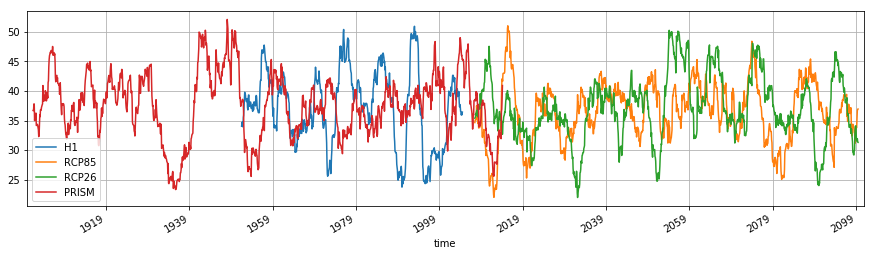

In [24]:
ax = h_filt.plot(figsize=(15,4))
rcp85_filt.plot(ax=ax)
rcp26_filt.plot(ax=ax)
prism_filt.plot(ax=ax)
ax.grid(True)

As we can see from the above plot, the CCSM model historical run shows a few droughts comperable to the Dust Bowl in the 30's and Texas Drought in the 50's.  In terms of drought in the future, the CCSM "Best Case" and "Worst Case" is not qualtiatively different.

Now just to show that we can access more than climate model time series, let's extract precipitation data from a dry winter (1936-1937) and a normal winter (2009-2010) for Texas County and look at the spatial patterns.  

We'll use the Xarray, which allows us to open OPeNDAP datasets just as if they were local NetCDF files, and uses a NetCDF data model to allow easy pandas-like slicing to extract data based on actual longitude, latitude and time values, rather than indices.  It also uses lazy evaluation of data, which means that data is only extracted when you actually do something with it.  It also uses the Dask package behind the scenes to handle out of memory calculations.  So you can compute the mean of some climate data that would be much larger than memory and it handles it automagically.

In [25]:
import xarray as xr

url = 'https://cida.usgs.gov/thredds/dodsC/prism_v2'
ds = xr.open_dataset(url)

In [26]:
# Bounding box for Texas County, Oklahoma
ds_texas = ds.sel(lon=slice(-102.0, -101.0), lat=slice(37.0, 36.5))

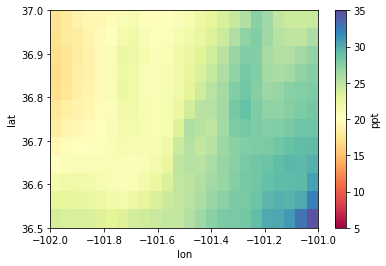

In [27]:
# Normal winter
ds1 = ds_texas.sel(time=slice('2009-11-01', '2010-04-01'))
                   
ds1['ppt'].mean('time').plot.pcolormesh(vmin=5, vmax=35, cmap='Spectral');

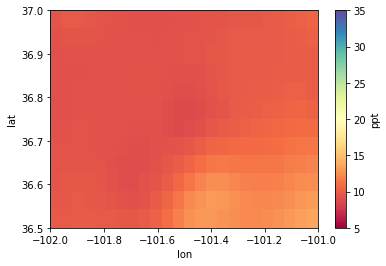

In [28]:
# Dry winter
ds2 = ds_texas.sel(time=slice('1936-11-01', '1937-04-01'))

ds2['ppt'].mean('time').plot.pcolormesh(vmin=5, vmax=35, cmap='Spectral')

From the above patterns, we can see that it's significantly drier in the northwestern part of the county in both years.  We can also see that the *maximum* precip in 1936-1937 is less than the *minimum* precipitation in 2009-2010. 

Hopefully this demo inspires other investigation of historical and projected climate data using the GDP and Python.  